# Introduction to LIGO Skymaps
In this first tutorial we will learn the basics of LIGO sky localiztion probability maps (skymaps).

We will cover a) downloading and reading in the Flexible Image Transport System (FITS) files, b) getting header information for skymaps, c) getting probabilities given line of sight (right ascension/declination), d) finding the maximum probability density pixel, e) creating skymap plots with galactic coordinates, f) selecting the 50% and 90% probability regions, and g) down-sampling the map to coarser resolutions.

## Setting up the Python Environment
The following packages are needed for working with LIGO skymaps: Astropy, Healpy, and Numpy. We will also utilize Matplotlib, Scipy, and Astroquery. All of these packages can be installed using Pip.

In [1]:
import sys
!{sys.executable} -m pip install "astropy" "astroquery" "healpy" "matplotlib" "scipy"

All LIGO skymaps are stored as FITS files. The FITS files contain a single binary table that represent a HEALPix (Hierarchical Equal Area isoLatitude Pixelization) all-sky image.
For compact binary mergers, 3-D skymaps (distance + directional information) are provided. These tables have four columns: PROB, DISTMU, DISTSTD, and DISTNORM.
For burst triggers, 2-D skymaps are generated with only directional information. These tables only have one column.

More on this later.... Now that we have installed the packages successfully, let us try importing the necessary packages for working with the HEALPix files.

## Import necessary packages 

In [2]:
import healpy as hp # for working with HEALPix files
import numpy as np # needed for vector operations
from matplotlib import pyplot as plt # plotting skymaps
from scipy.stats import norm # probability functions

We will download a skymap from the BNS merger event, GW170817.
Specifically, we will use the publication LALInference skymap.
All skymaps relevant for this event released from the LIGO-Virgo side can be found here: https://dcc.ligo.org/LIGO-G1701985/public

In [3]:
from astropy.utils.data import download_file
url = ('https://dcc.ligo.org/public/0146/G1701985/001/LALInference_v2.fits.gz')
# This is the publication LALInference localization
filename = download_file(url, cache=True)

Now, when we read in the HEALPix file with Healpy, we get a skymap and a header. The skymap contains the first column which is the probability sky map. For 3D skymaps, 3 additional columns remain which are DISTMU, DISTSTD, and DISTNORM.

## Reading in the skymap and header with Healpy

In [4]:
prob, header = hp.read_map(filename, h=True) # reading in the first column which is the probability skymap and the header

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


Now, because we are working with a 3D skymap, we will read in distance information as well: distmu and distsigma (the ansatz location and scale parameters), and distnorm (the ansatz normalization coefficient).

In [5]:
distmu, distsigma, distnorm = hp.read_map(filename, field=[1,2,3])

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


Because we read in the header (which contains relevant metadata about the event and the skymap), we will print it explicitly. Often, the circulars written by the LIGO and Virgo Collaborations contain information from the skymap headers.

In [6]:
header

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 32),
 ('NAXIS2', 12582912),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 4),
 ('TTYPE1', 'PROB'),
 ('TFORM1', 'D'),
 ('TUNIT1', 'pix-1'),
 ('TTYPE2', 'DISTMU'),
 ('TFORM2', 'D'),
 ('TUNIT2', 'Mpc'),
 ('TTYPE3', 'DISTSIGMA'),
 ('TFORM3', 'D'),
 ('TUNIT3', 'Mpc'),
 ('TTYPE4', 'DISTNORM'),
 ('TFORM4', 'D'),
 ('TUNIT4', 'Mpc-2'),
 ('PIXTYPE', 'HEALPIX'),
 ('ORDERING', 'NESTED'),
 ('COORDSYS', 'C'),
 ('NSIDE', 1024),
 ('INDXSCHM', 'IMPLICIT'),
 ('OBJECT', 'GW170817'),
 ('DATE-OBS', '2017-08-17T12:41:04.429237'),
 ('MJD-OBS', 57982.52852348645),
 ('DATE', '2017-09-26T14:24:08.382958'),
 ('CREATOR', 'run_sky_area'),
 ('ORIGIN', 'LIGO/Virgo'),
 ('DISTMEAN', 38.58938617448738),
 ('DISTSTD', 6.996864447652665),
 ('VCSVERS', 'skyarea 0.3.2'),
 ('VCSSTAT', ''),
 ('VCSREV', ''),
 ('DATE-BLD', ''),
 ('HISTORY', ''),
 ('HISTORY', 'Generated by running the following script:'),
 ('HISTORY',
  'run_sky_area -j --seed 150914 --samples 

Next, it will be useful for us to have the HEALPix resolution on hand.

In [7]:
npix = len(prob)
nside = hp.npix2nside(npix)
print(npix, nside)

(12582912, 1024)


## 2D Probability in a Given Line of Sight

We want to be able to compute the probability per deg$^2$ that the source is in a given direction.
Let us take the following equatorial coordinates.

In [8]:
ra, dec = 197.45, -23.38 # Coordinates of NGC 4993

Healpy uses spherical coordinates $(\theta, \phi)$ with $\theta \in [0, \pi]$ being the colatitude from the north celestial pole in radians, and $\phi \in [0, 2\pi)$ being the right ascension in radians.

In [9]:
# Converting to radians
theta = 0.5*np.pi - np.deg2rad(dec)
phi = np.deg2rad(ra)
print(theta, phi)

(1.9788543059111707, 3.4461526080628033)


Now, we look up the index of the HEALPix pixel that contains this direction.

In [10]:
ipix = hp.ang2pix(nside, theta, phi)
ipix

8790214

Now, we need to know what the area per pixel is in steradians and then use this to compute the probability contained within the ipix pixel.

In [11]:
# Area per pixel in steradians
pixarea = hp.nside2pixarea(nside)
# Conversion to deg^2
pixarea_deg2 = hp.nside2pixarea(nside, degrees=True)
# Probability contained in pixel ipix divided by the area per pixel
dp_dA = prob[ipix]/pixarea # Probability per steradian
dp_dA_deg2 = prob[ipix]/pixarea_deg2 # Probability per deg^2
print(dp_dA_deg2)

0.0895948754624


## Conditional Distance Distribution along a Line of Sight

Next, let us calculate the conditional distance distribution along a given line of sight. In other words, this is the probability per unit distance under the assumption that the source is in a given direction.

We first lay out a grid in distance along that line of sight.

In [12]:
r = np.linspace(0,80,100) # Returns 100 evenly spaced numbers between 0 and 80

Now, we plug everyting into the ansatz distribution. The probability that a source is within pixel $i$ and at a distance between $r$ and $r + dr$ is:
\begin{equation*}
P(r, \vec{n}_i) dr = \rho_i \frac{\hat{N}_i}{\sqrt{2\pi}\hat{\sigma}_i} \text{exp} \left[-\frac{(r-\hat{\mu}_i)^2}{2\hat{\sigma}_i^2} \right] r^2 dr
\end{equation*}


In [13]:
dp_dr = r**2 * distnorm[ipix] * norm(distmu[ipix], distsigma[ipix]).pdf(r)

Now, we can plot the result.

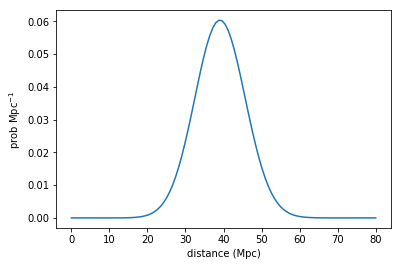

In [14]:
plt.plot(r, dp_dr)
plt.xlabel('distance (Mpc)')
plt.ylabel('prob Mpc$^{-1}$')
plt.show()

## Probability per Unit Volume at a Point 

Now, we can calculate the probability density per Mpc$^3$ at a point. We can use the same right ascension and declination as above and the distance to NGC 4993, which is 40 Mpc.

In [15]:
r = 40

In [16]:
dp_dV = prob[ipix]*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r)/pixarea
dp_dV

0.01098675457913202

## THIS IS JUST A PLACEHOLDER

More things to include in this tutorial:
1. Finding the maximum probabiity density pixel
2. Creating skymap plots with galactic coordinates
3. Selecting the 50% and 90% probability regions
4. Down-sampling the map to coarser resolutions

Separate tutorial for Large FOV instruments:
1. Capturing a rectangular/circular/other shape region in the sky that captures the most probability

Separate tutorial for Small FOV instruments:
1. Combining our skymaps with galaxy catalogs to get a list of galaxies for individual pointings (specific to 3D skymaps only)
2. Mention GWSky by Giuseppe Greco (https://github.com/ggreco77/GWSky)